# Aversarial Perturbations and Robust Training

In this notebook we explore adversarial perturbations and robustness of deep learning models. As per the seminal paper 'Adversarial Examples Are Not Bugs, They Are Features', deep learning models tend to learn **robust** and **non-robust features**. 

## Robust Features
Features that are **useful for classification** and remain **predictive under adversarial perturbations**.

- **Human-aligned**: Correspond to easily human-recognizable patterns
- **Stable**: Aligned with the correct target class even when the image is slightly perturbed
- **Examples**: Shape, texture, semantic content (ears, eyes, fur for dogs)
- **Survive adversarial attacks**: Still present and useful after small perturbations

## Non-Robust Features
Features that are **useful for classification** on the original distribution but become **unpredictive or flip** under small adversarial perturbations.

- **Imperceptible to humans**: Often not noticed or used by human vision
- **Still predictive**: Correctly correlated with correct labels in the original dataset/distribution
- **Brittle**: Highly sensitive to small input changes - small changes to these will align them with incorrect classes

The tiny perturbations we create exploit **non-robust features** while leaving **robust features** (visible shape, structure) unchanged - explaining why adversarial examples look identical to humans but fool models.




In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

Let's first load the image of a golden retriever and convert it to a tensor

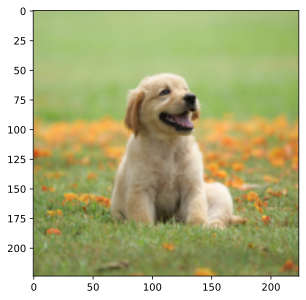

In [2]:
from PIL import Image
from torchvision import transforms

# read the image, resize to 224 and convert to PyTorch Tensor
dog_img = Image.open("dog.jpg")
preprocess = transforms.Compose([
   transforms.Resize(224),
   transforms.ToTensor(),
])
dog_tensor = preprocess(dog_img)[None,:,:,:]

# plot image (note that numpy using HWC whereas Pytorch user CHW, so we need to convert)
plt.imshow(dog_tensor[0].numpy().transpose(1,2,0))

We'll now load a pre-trained vision model (ResNet50) and check its prediction class

In [31]:
import torch
import torch.nn as nn
from torchvision.models import resnet50

# image normalization module

class Normalize(nn.Module):
    def __init__(self, mean, std):
        super(Normalize, self).__init__()
        self.mean = torch.Tensor(mean)
        self.std = torch.Tensor(std)
    
    def forward(self, x):
        return (x - self.mean.type_as(x)[None, :, None, None]) / self.std.type_as(x)[None, :, None, None]

# mean and std are standard normalization values for ImageNet images 
norm = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

model = resnet50(pretrained=True)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Let's check the initial predicted classes and its probability of this puppy's picture

In [25]:
imagenet_classes = {int(i):x[1] for i,x in json.load(open('imagenet_class_index.json')).items()}

In [32]:
import json

pred = model(norm(dog_tensor))
pred_label = torch.argmax(pred, axis=1)
print(pred_label)
print(imagenet_classes[pred_label.item()]) 
print(nn.Softmax(dim=1)(pred)[0,207].item()) # probability of label 207 (golden retriever)


tensor([207])
golden_retriever
0.7470424175262451


## Training an adversarial example

Now we'll modify this puppy's picture itself ever so slightly to be misclassified by the model - it'll still look like a golden retriever to humans, but not to the model. Two popular methods to achieve the same are **Fast Gradient Sign Method (FGSM)** and **Projected Gradient Descent (PGD)**, which differ only slightly. 

Just like training a model, we create a delta tensor (initialized with all zeroes) to be added to the original picture. We bound it by some epsilon such $\|\boldsymbol{\delta}\|_\infty \leq \varepsilon$ (other norms like $L_2$ norms can be used as well) to ensure that perturbations are imperceptible to humans, and then train delta to maximize the original model's loss function instead of minimizing it. 

$$\boldsymbol{\delta}^* = \arg\max_{\|\boldsymbol{\delta}\|_\infty \leq \varepsilon} \mathcal{L}_{CE}(f_\theta(\mathbf{x} + \boldsymbol{\delta}), y_{true})$$

Where:
- $\mathbf{x}$ is the original input image
- $\boldsymbol{\delta}$ is the adversarial perturbation we're optimizing
- $f_\theta$ is our neural network with parameters $\theta$
- $y$ is the true label
- $\mathcal{L}_{CE}$ is the standard cross entropy function. 
- $\varepsilon$ is the perturbation bound

This method is called the **Projected Gradient Descent**, as it utilizes gradient descent to maximize loss for a particular input image. The 'projected' comes from projecting delta to the epsilon bound space (when using $L_\infty$ norm as in our case, it is simply clamping delta to be within $(-\varepsilon, \varepsilon)$). 

**Fast Gradient Sign Method** is a simpler and faster version of PGD - instead of optmizing over multiple iterations, we calculate the gradient from one backward pass and simply take one large step in the direction of the gradient sign:

$$\boldsymbol{\delta} = \varepsilon \cdot \text{sign}(\nabla_{\mathbf{x}} \mathcal{L}(f_\theta(\mathbf{x}), y))$$

This creates the adversarial example in a single step: $\mathbf{x}_{adv} = \mathbf{x} + \boldsymbol{\delta}$, making it much faster than PGD but typically less effective at finding strong adversarial perturbations.

In this notebook, we've implemented the PGD approach.

### The PGD Attack Process

1. **Initialize**: $\boldsymbol{\delta} = \mathbf{0}$
2. **Forward pass**: Compute $\text{pred} = f_\theta(\mathbf{x} + \boldsymbol{\delta})$
3. **Compute loss**: $\mathcal{L} = -\text{CrossEntropy}(\text{pred}, y)$ (note the negative sign for maximization!)
4. **Backward pass**: Compute $\nabla_{\boldsymbol{\delta}} \mathcal{L}$
5. **Update**: $\boldsymbol{\delta} \leftarrow \boldsymbol{\delta} + \alpha \cdot \text{sign}(\nabla_{\boldsymbol{\delta}} \mathcal{L})$
6. **Project**: $\boldsymbol{\delta} \leftarrow \text{clamp}(\boldsymbol{\delta}, -\varepsilon, \varepsilon)$
7. **Repeat** steps 2-6 until convergence or maximum iterations




Humans can't detect changes smaller than 3-5 pixel values, thus 2 is a good epsilon value. (it becomes 2/255 after normalization)

In [33]:
import torch.optim as optim
epsilon = 2./255

delta = torch.zeros_like(dog_tensor, requires_grad=True)
optimizer = optim.SGD([delta], lr=0.01)

for step in range(100):
    pred = model(norm(dog_tensor + delta))
    loss = -nn.CrossEntropyLoss()(pred, torch.LongTensor([207]))

    if step % 10 == 0:
        print(step, loss.item())

    optimizer.zero_grad() # set all previous gradients to zero
    loss.backward() # backpropagate and compute gradients
    optimizer.step() # update delta using the gradients
    delta.data.clamp_(-epsilon, epsilon) # clamp to ensure ||delta||_inf <= epsilon

print("True class probability:", nn.Softmax(dim=1)(pred)[0,207].item())

0 -0.2916333079338074
10 -12.26797103881836
20 -16.485090255737305
30 -19.23815155029297
40 -21.035400390625
50 -22.14455795288086
60 -24.087614059448242
70 -23.764137268066406
80 -25.212289810180664
90 -25.301010131835938
True class probability: 3.0465196337869926e-12


Here's the modified image - which looks exactly the same!

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.007843138..1.0039216].


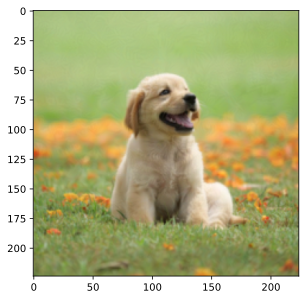

In [34]:
plt.imshow((dog_tensor + delta)[0].detach().numpy().transpose(1,2,0))

And here's the perturbation - impercebticle to us

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.007843138..0.007843138].


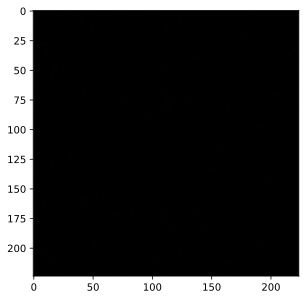

In [44]:
plt.imshow((delta)[0].detach().numpy().transpose(1,2,0))

But hey - just to visualize that there actually are perturbations made - here's an amplified visual of the perturbations. The values are shifted by 0.5 to accomodate the negative perturbations which are otherwise interpreted as black pixels.

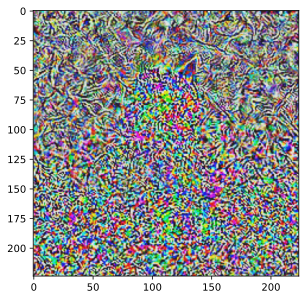

In [45]:
plt.imshow((50*delta+0.5)[0].detach().numpy().transpose(1,2,0))

And now, the predicted class of the modified image by the same model. The classification is now a labrador retriever!

In [35]:
model.eval()
pred = model(norm(dog_tensor + delta))
pred_label = torch.argmax(pred, axis=1)

max_class = pred.max(dim=1)[1].item()
print("Predicted class: ", imagenet_classes[max_class])
print("Predicted probability:", nn.Softmax(dim=1)(pred)[0,max_class].item())


Predicted class:  Labrador_retriever
Predicted probability: 0.9999959468841553


## Targeted Adversarial Example

To be fair though, a labrador retriever does look pretty similar to a golden retriever. So we'll go a bit further and try to make our model classify this puppy's image as a pizza (or any other class of your choice). 

To do so, we just need to make a very small change - instead of just maximizing the cross entropy loss w.r.t. the correct class, we will simultaneously minimize (or maximize the negative of) the cross entropy loss w.r.t. our adversarial target's class (pizza's class). 

So our loss function ends up looking like this: 

$$\mathcal{L}_{targeted} = \left(\mathcal{L}_{CE}(f_\theta(\mathbf{x} + \boldsymbol{\delta}), y_{true}) - \mathcal{L}_{CE}(f_\theta(\mathbf{x} + \boldsymbol{\delta}), y_{target})\right)$$

Where:
- $y_{true}$ is the correct class (Golden Retriever, class 207)
- $y_{target}$ is our desired target class (Pizza, class 963)
- $\mathcal{L}_{CE}$ is the cross-entropy loss

In [80]:
# Search for adversarial class id
adversarial_class = None
for class_id, class_name in imagenet_classes.items():
    if 'pizza' in class_name.lower():
        adversarial_class = class_id
        print(f"Class ID: {class_id}, Class Name: {class_name}")
        break

if adversarial_class:
    print(f"Adversarial class ID: {adversarial_class}")
else:
    print("Adversarial class not found in ImageNet classes")

Class ID: 963, Class Name: pizza
Adversarial class ID: 963


In [37]:
epsilon = 2./255

delta = torch.zeros_like(dog_tensor, requires_grad=True)
optimizer = optim.SGD([delta], lr=0.01)

for step in range(100):
    pred = model(norm(dog_tensor + delta))
    loss = -(nn.CrossEntropyLoss()(pred, torch.LongTensor([207])) - nn.CrossEntropyLoss()(pred, torch.LongTensor([963])))

    if step % 10 == 0:
        print(step, loss.item())

    optimizer.zero_grad() # set all previous gradients to zero
    loss.backward() # backpropagate and compute gradients
    optimizer.step() # update delta using the gradients
    delta.data.clamp_(-epsilon, epsilon) # clamp to ensure ||delta||_inf <= epsilon

print("True class probability:", nn.Softmax(dim=1)(pred)[0,207].item())

0 15.078178405761719
10 -17.011362075805664
20 -27.89098358154297
30 -35.25243377685547
40 -40.2655029296875
50 -40.492733001708984
60 -43.94534683227539
70 -42.0980224609375
80 -44.849369049072266
90 -40.3809700012207
True class probability: 2.6633794007529666e-21


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.007843138..1.0078431].


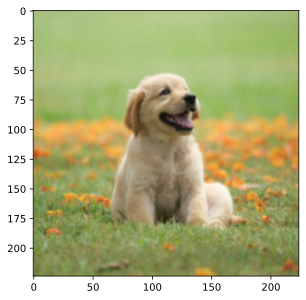

In [41]:
plt.imshow((dog_tensor + delta)[0].detach().numpy().transpose(1,2,0))

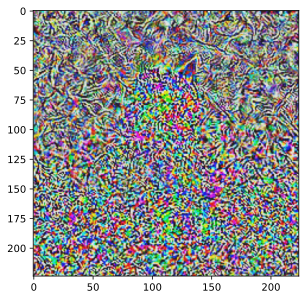

In [43]:
plt.imshow((50*delta+0.5)[0].detach().numpy().transpose(1,2,0))

And indeed, we could easily modify our image to classified as pizza instead - which can be done for any class.

In [38]:
model.eval()
pred = model(norm(dog_tensor + delta))
pred_label = torch.argmax(pred, axis=1)

max_class = pred.max(dim=1)[1].item()
print("Predicted class: ", imagenet_classes[max_class])
print("Predicted probability:", nn.Softmax(dim=1)(pred)[0,max_class].item())

Predicted class:  pizza
Predicted probability: 0.9999997615814209


# Training a robust model

Now let's get to the thick of it. To avoid being vulnerable to adversarial attacks, we need to train them on adversarial examples during the training process itself. This is called **Adversarial Training** or **Robust Training**.

Now, we do run into a min-max problem: instead of training on clean data and only minimizing the loss:
$$\min_{\theta} \mathbb{E}_{(x,y) \sim \mathcal{D}} [\mathcal{L}(f_\theta(x), y)]$$

We now also have to first maximize loss for adversarial examples and then minimize overall loss on these examples:
$$\min_{\theta} \mathbb{E}_{(x,y) \sim \mathcal{D}} \left[ \max_{\|\delta\|_\infty \leq \varepsilon} \mathcal{L}(f_\theta(x + \delta), y) \right]$$

This is a non trivial problem. 

To tackle the inner maximization problem (finding our delta), there are three appraoches:

### 1. Lower Bounds on $\delta$

This approach find adversarial perturbations that provide a lower bound on the true maximum loss. This is fast and practical, but may not find the true worst-case perturbation. FGSM and PGD are examples of this approach, as the worst adversarial examples (that maximize the loss) will be at least as good as the adveersarial examples produced by FGSM and PGD.

### 2. Exact Solutions for $\delta$

This approach finds the __exact__ solutions the min-max problem by optimization techniques like Mixed-Integer Programming. Since this is a combinatorial problem, its very computationally intensive (like, __very__) and is often only used for smaller models for research purposes.

### 3. Upper Bounds on $\delta$

This approach finds an upper bound on the maximum possible loss by relaxing the non-convex constraints with some convex approaximations. These can sometimes result in upper bounds that are too loose (much greater than the actual upper bound), leading to over conservative models with lower accuracy. 


Method 1 is the most popular and practical approach, which we'll be stick with for our adversarial training.



To test out the performance of adversarially trained models vs normally trained models, we'll train a standard CNN on the MNIST dataset from scratch. The adversarial training algorithm will be:

1. **Select minibatch** $B$, initialize gradient vector $g := 0$
2. **For each** $(x,y)$ in $B$:
   - a. Find an attack perturbation $\delta^{\star}$ by (approximately) optimizing:
     $$\delta^{\star} = \arg\max_{\|\delta\|_\infty \leq \varepsilon} \mathcal{L}(f_\theta(x + \delta), y)$$
   - b. Add gradient at $\delta^{\star}$:
     $$g := g + \nabla_\theta \mathcal{L}(f_\theta(x + \delta^{\star}), y)$$
3. **Update parameters** $\theta$:
   $$\theta := \theta - \frac{\alpha}{|B|} g$$

This process makes the model robust to perturbations within the $\varepsilon$-ball.


In [46]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

mnist_train = datasets.MNIST("../data", train=True, download=True, transform=transforms.ToTensor())
mnist_test = datasets.MNIST("../data", train=False, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(mnist_train, batch_size = 100, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size = 100, shuffle=False)

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

100%|██████████| 9.91M/9.91M [00:00<00:00, 13.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 343kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.18MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 1.21MB/s]

Using device: mps


In [67]:
torch.manual_seed(19)

class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)

model = nn.Sequential(
    nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1), # 28x28x1 -> 28x28x32
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),              # 28x28x32 -> 14x14x32
    nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1), # 14x14x32 -> 14x14x64
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),              # 14x14x64 -> 7x7x64
    Flatten(),                                          # 7x7x64 -> 3136
    nn.Linear(7*7*64, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)

model.to(device)

Sequential(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten()
  (7): Linear(in_features=3136, out_features=128, bias=True)
  (8): ReLU()
  (9): Linear(in_features=128, out_features=10, bias=True)
)

In [ ]:
def fgsm(model, X, y, epsilon=0.1):
    '''Constructs FGSM adversarial examples on data'''
    delta = torch.zeros_like(X, requires_grad=True)

    pred = model(X + delta)
    loss = nn.CrossEntropyLoss()(pred, y)
    loss.backward() # backpropagate and compute gradients

    return epsilon * delta.grad.detach().sign()

def pgd(model, X, y, alpha=0.01, epsilon=0.1, iter=100, randomize=False):
    '''Constructs PGD adversarial examples on data'''
    if randomize:
        delta = torch.rand_like(X, requires_grad=True)
        delta.data = delta.data * 2 * epsilon - epsilon  # Scale to [-ε, ε]
    else:
        delta = torch.zeros_like(X, requires_grad=True)
    
    optimizer = optim.SGD([delta], lr=0.01)

    for step in range(iter):
        pred = model(X + delta)
        loss = nn.CrossEntropyLoss()(pred, y)
        optimizer.zero_grad() # set all previous gradients to zero
        loss.backward() # backpropagate and compute gradients
        optimizer.step() # update delta using the gradients
        delta.data = (delta + alpha*delta.grad.detach().sign()).clamp(-epsilon,epsilon) # clamp to ensure ||delta||_inf <= epsilon
    
    # .detach() is better as it separates the tensor from its computational gradient graph and frees up memory
    return delta.detach()

def epoch(loader, model, optimizer=None):
    total_loss = 0
    total_error = 0

    for X, y in loader:
        X, y = X.to(device), y.to(device)
        pred = model(X)

        loss = nn.CrossEntropyLoss()(pred, y)
        total_loss += loss.item() * y.size(0)
        total_error += (pred.max(1)[1] != y).sum().item()

        if optimizer:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    return total_loss / len(loader.dataset), total_error / len(loader.dataset)


def epoch_adversarial(loader, model, attack, optimizer=None):
    total_loss = 0
    total_error = 0

    for X, y in loader:
        X, y = X.to(device), y.to(device)
        delta = attack(model, X, y)
        pred = model(X + delta)

        loss = nn.CrossEntropyLoss()(pred, y)
        total_loss += loss.item() * y.size(0)
        total_error += (pred.max(1)[1] != y).sum().item()

        if optimizer:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    return total_loss / len(loader.dataset), total_error / len(loader.dataset)



    

Let's test the performace of a normally trained CNN

In [68]:
optimizer = optim.SGD(model.parameters(), lr=1e-1)

for e in range(10):
    train_loss, train_error = epoch(train_loader, model, optimizer)
    test_loss, test_error = epoch(test_loader, model)
    test_loss_adv, test_error_adv = epoch_adversarial(test_loader, model, pgd)

    print(f"Epoch {e}: Train loss {train_loss:.3f}, Train error {train_error:.3f}, Test loss {test_loss:.3f}, Test error {test_error:.3f}\n, Adversarial Test loss {test_loss_adv:.3f}, Adversarial Test error {test_error_adv:.3f}")


Epoch 0: Train loss 0.430, Train error 0.139, Test loss 0.089, Test error 0.029
, Adversarial Test loss 1.274, Adversarial Test error 0.400
Epoch 1: Train loss 0.085, Train error 0.026, Test loss 0.061, Test error 0.021
, Adversarial Test loss 1.303, Adversarial Test error 0.394
Epoch 2: Train loss 0.059, Train error 0.018, Test loss 0.055, Test error 0.018
, Adversarial Test loss 1.409, Adversarial Test error 0.422
Epoch 3: Train loss 0.045, Train error 0.014, Test loss 0.042, Test error 0.014
, Adversarial Test loss 1.417, Adversarial Test error 0.410
Epoch 4: Train loss 0.037, Train error 0.012, Test loss 0.037, Test error 0.013
, Adversarial Test loss 1.683, Adversarial Test error 0.446
Epoch 5: Train loss 0.031, Train error 0.010, Test loss 0.031, Test error 0.010
, Adversarial Test loss 1.642, Adversarial Test error 0.432
Epoch 6: Train loss 0.026, Train error 0.008, Test loss 0.032, Test error 0.011
, Adversarial Test loss 1.707, Adversarial Test error 0.453
Epoch 7: Train loss 

And then a robust CNN which is adversarially trained

In [75]:
model_robust = nn.Sequential(
    nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1), # 28x28x1 -> 28x28x32
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),              # 28x28x32 -> 14x14x32
    nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1), # 14x14x32 -> 14x14x64
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),              # 14x14x64 -> 7x7x64
    Flatten(),                                          # 7x7x64 -> 3136
    nn.Linear(7*7*64, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)

model_robust.to(device)

Sequential(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten()
  (7): Linear(in_features=3136, out_features=128, bias=True)
  (8): ReLU()
  (9): Linear(in_features=128, out_features=10, bias=True)
)

In [ ]:
#optimizer = optim.SGD(model_robust.parameters(), lr=0.1)

for e in range(10):
    train_loss, train_error = epoch_adversarial(train_loader, model_robust, pgd, optimizer)
    test_loss, test_error = epoch(test_loader, model_robust)
    test_loss_adv, test_error_adv = epoch_adversarial(test_loader, model_robust, pgd)

    if e == 4:
        for param_group in optimizer.param_groups:
            param_group["lr"] = 1e-2

    print(f"Epoch {e}: Train loss {train_loss:.3f}, Train error {train_error:.3f}, Test loss {test_loss:.3f}, Test error {test_error:.3f}\n, Adversarial Test loss {test_loss_adv:.3f}, Adversarial Test error {test_error_adv:.3f}")


Epoch 0: Train loss 1.338, Train error 0.483, Test loss 0.137, Test error 0.039
, Adversarial Test loss 0.398, Adversarial Test error 0.132
Epoch 1: Train loss 0.328, Train error 0.109, Test loss 0.072, Test error 0.020
, Adversarial Test loss 0.255, Adversarial Test error 0.085
Epoch 2: Train loss 0.235, Train error 0.077, Test loss 0.052, Test error 0.017
, Adversarial Test loss 0.190, Adversarial Test error 0.060
Epoch 3: Train loss 0.194, Train error 0.064, Test loss 0.047, Test error 0.015
, Adversarial Test loss 0.179, Adversarial Test error 0.060


NameError: name 'opt' is not defined

In [77]:
for e in range(4,10):
    train_loss, train_error = epoch_adversarial(train_loader, model_robust, pgd, optimizer)
    test_loss, test_error = epoch(test_loader, model_robust)
    test_loss_adv, test_error_adv = epoch_adversarial(test_loader, model_robust, pgd)

    if e == 4:
        for param_group in optimizer.param_groups:
            param_group["lr"] = 1e-2

    print(f"Epoch {e}: Train loss {train_loss:.3f}, Train error {train_error:.3f}, Test loss {test_loss:.3f}, Test error {test_error:.3f}\n, Adversarial Test loss {test_loss_adv:.3f}, Adversarial Test error {test_error_adv:.3f}")


Epoch 4: Train loss 0.145, Train error 0.048, Test loss 0.038, Test error 0.014
, Adversarial Test loss 0.144, Adversarial Test error 0.049
Epoch 5: Train loss 0.114, Train error 0.038, Test loss 0.032, Test error 0.011
, Adversarial Test loss 0.128, Adversarial Test error 0.043
Epoch 6: Train loss 0.111, Train error 0.036, Test loss 0.032, Test error 0.010
, Adversarial Test loss 0.127, Adversarial Test error 0.043
Epoch 7: Train loss 0.109, Train error 0.036, Test loss 0.031, Test error 0.010
, Adversarial Test loss 0.126, Adversarial Test error 0.042
Epoch 8: Train loss 0.107, Train error 0.035, Test loss 0.031, Test error 0.010
, Adversarial Test loss 0.124, Adversarial Test error 0.041
Epoch 9: Train loss 0.106, Train error 0.035, Test loss 0.030, Test error 0.010
, Adversarial Test loss 0.124, Adversarial Test error 0.041


Voila! An adversarially trained robust model performs much better against adversarial and normal examples both. 

In [78]:
torch.save(model_robust.state_dict(), "mnist_cnn_robust.pth")
torch.save(model.state_dict(), "mnist_cnn.pth")

## Evaluating The Robust Model